In this notebook, I implement an MLP classifier from scratch, without using the backpropagation framework built into PyTorch. Doing so requires implementing backpropagation from scratch.

### Step 1: Download FashionMNIST Dataset

Use `torchvision.datasets`

In [ ]:
import itertools
import math

import torch
from torchvision.datasets import FashionMNIST, MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from utils.data import get_root

In [ ]:
datadir = get_root() + '/computer_vision/datasets'
transform = transforms.Compose([transforms.ToTensor()])
#train_data = FashionMNIST(datadir, train=True, transform=transform, download=True)
#val_data = FashionMNIST(datadir, train=False, transform=transform, download=True) 
train_data = MNIST(datadir, train=True, transform=transform, download=True)
val_data = MNIST(datadir, train=False, transform=transform, download=True)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

### Step 2: Create DataLoader

Use `torch.utils.data.TensorDataset` and `torch.utils.data.DataLoader`. Use `batch_size = 64`.

In [4]:
from torch.utils.data import DataLoader

In [5]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
val_dl = DataLoader(val_data, batch_size=64)

In [6]:
print(train_dl)
X, y = next(iter(train_dl))
print(X.shape, y.shape, X.max(), y.max())

torch.Size([64, 1, 28, 28]) torch.Size([64]) tensor(1.) tensor(9)


### Step 3: Create MLP Class 

The way I'll do this is I'll create a base class `Primitive`, which implements the methods `forward()` and `backward()`. The forward functions store the variables needed for the backward pass, and return the vector-Jacobian product on the backward pass. I'll also create a class `Module`, which is a subclass of `Primitive` and which also have the methods `get_params()` and `get_param_grads()`. These functions return iterators. Modules must also update the parameter gradients during the backward pass. The overall network (which subclasses `Module`) will be made up of layers (subclasses of `Primitive`) which update the parameter gradients during the `backward` function. 

There will be a global variable `no_grad` in the Primitive module, which determines whether the variables are saved for the backwards pass. Backwards calls an `Exception` if it is called while `no_grad` is `true`. We'll implement this as a context manager in the class `Primitive`. 

Our network will be a class `MLP` which subclasses `Module`. 

In [7]:
from abc import ABC, abstractmethod

In [8]:
no_grad = False # global variable

class Primitive(ABC):
    
    def __call__(self, *args):
        return self.forward(*args)
    
    @abstractmethod
    def forward(self):
        pass

    @abstractmethod
    def backward(self):
        pass


class Module(Primitive):
    @abstractmethod
    def get_params(self):
        pass

In [9]:
class ReLU(Primitive):
    def forward(self, x):
        out = torch.max(torch.zeros_like(x), x)
        if not no_grad:
            self.saved_for_backward = (x > 0).type(torch.float32)
        return out

    def backward(self, v):
        elementwise_grad = self.saved_for_backward
        del self.saved_for_backward
        return v * elementwise_grad

class Linear(Module):
    def __init__(self, num_inputs, num_outputs):
        self.init_params(num_inputs, num_outputs)
    
    def init_params(self, num_inputs, num_outputs):
        """ Default initialization is Xavier init """
        self.weight = torch.randn(num_inputs, num_outputs) * math.sqrt(2 / (num_inputs + num_outputs))
        self.b = torch.zeros(num_outputs)
    
    def forward(self, x):
        if not no_grad:
            self.saved_for_backward = x
        return x @ self.weight + self.b

    def backward(self, v):
        x = self.saved_for_backward
        del self.saved_for_backward
        self.weight.grad = x.T @ v
        self.b.grad = v.sum(0)
        return v @ self.weight.T 

    def get_params(self):
        return self.weight, self.b

class MLP(Module):
    def __init__(self, num_layers, num_inputs, hidden_width, num_outputs):
        if num_layers == 1:
            self.layers = [Linear(num_inputs, num_outputs)]
            self.activations = []
        else:
            self.layers = [Linear(num_inputs, hidden_width)]
            self.activations = [ReLU()]
            for _ in range(num_layers - 2):
                self.layers.append(Linear(hidden_width, hidden_width))
                self.activations.append(ReLU())
            self.layers.append(Linear(hidden_width, num_outputs))

    def forward(self, x):
        x = x.reshape(-1, 784)
        for layer, activation in zip(self.layers[:-1], self.activations):
            x = layer(x)
            x = activation(x)
        return self.layers[-1](x)

    def backward(self, v):
        v = self.layers[-1].backward(v)
        for layer, activation in zip(self.layers[::-1][1:], self.activations[::-1]):
            v = activation.backward(v)
            v = layer.backward(v)
        v = v.reshape(-1, 1, 28, 28)
        return v

    def get_params(self):
        param_list = (layer.get_params() for layer in self.layers)
        return itertools.chain(*param_list)

Let's test that our model gives a reasonable output, and that we can compute the gradient without any errors.

In [10]:
model = MLP(3, 784, 32, 10)

In [11]:
X, y = next(iter(train_dl))
print(X.shape)
model(X).shape

torch.Size([64, 1, 28, 28])


torch.Size([64, 10])

In [12]:
v_test = torch.randn(64, 10)
model.backward(v_test).shape

torch.Size([64, 1, 28, 28])

### Step 4: Write Loss Function

The loss function will be of type `Primitive`. We can call `loss_fn.backward(torch.tensor(1))` to compute the gradient of the loss with respect to the loss inputs. The loss returns the value of the loss on the inputs. 

In [13]:
def softmax(z):
    exp = z.exp()
    return exp / exp.sum(1, keepdim=True)

def one_hot(y, num_dims):
    out = torch.zeros(y.shape[0], num_dims)
    out[torch.arange(y.shape[0]), y] += 1
    return out

class CategoricalCrossEntropyLoss(Primitive):
    def forward(self, logits, y):
        if not no_grad:
            self.saved_for_backward = softmax(logits), one_hot(y, logits.shape[1])
        return (-torch.gather(logits, 1, y.view(-1, 1)).squeeze() + logits.exp().sum(1).log()).mean(0)

    def backward(self, v):
        y_hat, one_hot_y = self.saved_for_backward
        del self.saved_for_backward
        return v * (y_hat - one_hot_y) / y_hat.shape[0]

In [14]:
loss_fn = CategoricalCrossEntropyLoss()

loss = loss_fn(model(X), y)
print(loss)

tensor(2.3339)


In [15]:
loss_fn.backward(torch.tensor(1.)).shape

torch.Size([64, 10])

### Step 5: Write Optimizer

The base `Optimizer` class will take as inputs a network of type `Module`, a loss function, and a learning rate. By calling `step(batch)`, the optimizer will update each parameter in the network using the function `update_param(param, param_grad)`. We will write a class `SGD` which subclasses `Optimizer`. 

In [16]:
class Optimizer(ABC):
    def step(self, model):
        for param in model.get_params():
            self.update_param(param)
        
    @abstractmethod
    def update_param(self):
        pass

In [17]:
class SGD(Optimizer):
    def __init__(self, lr):
        self.lr = lr

    def update_param(self, param):
        param -= self.lr * param.grad
        param.grad = None

In [18]:
optim = SGD(1e-2)

### Step 6: Create Trainer class

The `Trainer` class will be initialized with optimizer, loss function, and `num_epochs`. When the `fit` function is called, will take as inputs `model` and `dataloaders`. This will loop through the training dataset `num_epoch` times, at the end of each epoch compute the loss and accuracy on the validation set. Plot the training loss, validation loss, and validation accuracy over time.

In [19]:
class Trainer:
    def __init__(self, optimizer, loss_fn, num_epochs, plot_per_epoch=10):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.num_epochs = num_epochs
        self.plot_per_epoch = plot_per_epoch

    def accuracy(self, model, batch):
        X, y = batch
        no_grad = True
        logits = model(X)
        no_grad = False
        return (torch.argmax(logits, 1) == y).type(torch.float).mean()

    def loss(self, model, batch):
        X, y = batch
        logits = model(X)
        loss = self.loss_fn(logits, y)
        loss_grad = self.loss_fn.backward(torch.tensor(1.))
        model.backward(loss_grad)
        self.optimizer.step(model)
        return loss.item()
    
    def train_epoch(self, model, dl):
        losses = []
        n_plot = math.ceil(len(dl) // self.plot_per_epoch)
        l = 0.0
        for i, batch in enumerate(dl):
            if i > 0 and i % n_plot == 0:
                losses.append(l / n_plot)
                l = 0.0
            l += self.loss(model, batch)
        return losses
        
    def compute_val_accuracy(self, model, dl):
        accuracies = []
        n_plot = math.ceil(len(dl) // self.plot_per_epoch)
        for i, batch in enumerate(dl):
            accuracies.append(self.accuracy(model, batch).item())
        return sum(accuracies) / len(accuracies)

    def fit(self, model, train_dl, val_dl):
        losses, accuracies = [], []
        accuracies.append(self.compute_val_accuracy(model, val_dl))
        for n in range(self.num_epochs):
            print(f"epoch: {n+1}/{self.num_epochs}")
            losses.append(self.train_epoch(model, train_dl))
            accuracies.append(self.compute_val_accuracy(model, val_dl))
        return losses, accuracies

### Step 7: Perform Training Loop

Call `trainer.fit(model, dataloaders)` 

In [20]:
num_epochs = 5
optimizer = SGD(5e-2)
loss_fn = CategoricalCrossEntropyLoss()
model = MLP(3, 784, 32, 10)
trainer = Trainer(optimizer, loss_fn, num_epochs)

In [21]:
losses, val_accuracy = trainer.fit(model, train_dl, val_dl)

epoch: 1/5
epoch: 2/5
epoch: 3/5
epoch: 4/5
epoch: 5/5


In [22]:
print(losses)
print(val_accuracy)

[[1.5890350373842383, 0.6849260359041153, 0.46841291458375994, 0.4146878046374167, 0.3739471457978731, 0.3637116740467728, 0.34319953171796697, 0.3194495188773319, 0.3035542120536168, 0.29062519983578755], [0.27077419815524933, 0.2806745564905546, 0.2644061511883172, 0.24273640077601197, 0.26302881955459556, 0.22579261300063902, 0.23943145933651155, 0.22977337153047644, 0.24050904766366046, 0.22792954939187213], [0.22127707318593098, 0.2159363688320242, 0.21172574875495767, 0.19330793515007982, 0.1870685356759256, 0.1835372427137949, 0.20509020751842888, 0.1736079159603324, 0.18013054545047463, 0.19524429870709295], [0.18155976893600598, 0.1746155366862333, 0.16797744162300582, 0.1782081530940148, 0.1692886484326214, 0.17533976917145072, 0.1748782936683906, 0.150485537665826, 0.15786329280304653, 0.15598551308115324], [0.1499239907710142, 0.1427984751200163, 0.14630567106187983, 0.14320116442057393, 0.14685681650555263, 0.14792475304616395, 0.1502333273810725, 0.1540483284381128, 0.148

In [23]:
def flatten_2d_list(lst):
    return [item for inner_lst in lst for item in inner_lst]

def plot_metrics(losses, accuracies):
    fig, axs = plt.subplots(2, figsize=(5,6))
    losses = flatten_2d_list(losses)
    loss_epochs = torch.linspace(0, num_epochs, num_epochs*trainer.plot_per_epoch)
    axs[0].plot(loss_epochs, losses)
    axs[1].plot(accuracies)
    axs[0].set_ylim([0.0, max(losses) * 1.1])
    axs[1].set_ylim([0.0, 1.0])
    axs[0].set_ylabel("Training loss values")
    axs[1].set_ylabel("Validation Accuracy")
    axs[1].set_xlabel("Epochs")
    plt.show()

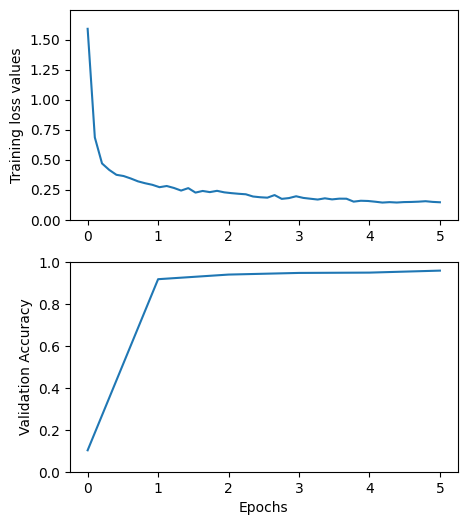

In [24]:
plot_metrics(losses, val_accuracy)